In [ ]:
# --- Install dependencies (Colab) ---
import sys, subprocess, pkg_resources

def pip_install(args):
    print("Installing:", ' '.join(args))
    return subprocess.check_call([sys.executable, "-m", "pip", "install", *args])

try:
    import torch
except Exception:
    pip_install(["torch", "torchvision", "torchaudio", "--index-url", "https://download.pytorch.org/whl/cpu"])
    import torch

torch_v = torch.__version__.split('+')[0]
print("Torch:", torch.__version__)

# Install PyG wheels compatible with the Torch version
wurl = f"https://data.pyg.org/whl/torch-{torch_v}+cpu.html"
to_install = [
    "torch_geometric",
    "torch_scatter",
    "torch_sparse",
    "torch_cluster",
]
pip_install([*to_install, "-f", wurl])

pip_install(["scikit-learn", "pandas", "matplotlib", "networkx", "numpy"])

/tmp/ipython-input-2924517861.py:2: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, subprocess, pkg_resources


Torch: 2.6.0+cu124
Installing: torch_geometric torch_scatter torch_sparse torch_cluster -f https://data.pyg.org/whl/torch-2.6.0+cpu.html
Installing: scikit-learn pandas matplotlib networkx numpy


0

In [ ]:

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve
from torch_geometric.data import Data
from torch_geometric.nn import GATConv

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
df_augmented = pd.read_csv('df_augmented_paysim.csv')  # path to downloaded CSV
print(f"Loaded augmented dataset: {df.shape[0]} rows, fraud proportion: {df['isFraud'].mean():.4f}")

Loaded augmented dataset: 50024 rows, fraud proportion: 0.1647


In [ ]:
# --- Build graph ---
accounts = pd.Index(pd.unique(pd.concat([df['nameOrig'], df['nameDest']], ignore_index=True)))
acc2id = {a:i for i,a in enumerate(accounts)}
src = df['nameOrig'].map(acc2id).astype(np.int64).values
dst = df['nameDest'].map(acc2id).astype(np.int64).values
edge_index = torch.from_numpy(np.vstack([src,dst]))

# --- Edge features ---
type_ohe = pd.get_dummies(df['type'], prefix='type')
edge_feats = pd.DataFrame({
    'amount': df['amount'].astype(float),
    'step': df['step'].astype(int),
    'deltaOrg': (df['oldbalanceOrg'] - df['newbalanceOrig']).astype(float),
    'deltaDest': (df['newbalanceDest'] - df['oldbalanceDest']).astype(float),
    'flagged': df.get('isFlaggedFraud', 0).astype(int),
})
edge_feats = pd.concat([edge_feats, type_ohe], axis=1)
scaler = StandardScaler()
for c in ['amount','step','deltaOrg','deltaDest']:
    edge_feats[c] = scaler.fit_transform(edge_feats[[c]])
edge_attr = torch.from_numpy(edge_feats.values.astype(np.float32))

# --- Node features ---
num_nodes = len(accounts)
deg_in  = np.bincount(dst, minlength=num_nodes)
deg_out = np.bincount(src, minlength=num_nodes)
node_x = torch.from_numpy(np.vstack([np.log1p(deg_in), np.log1p(deg_out)]).T.astype(np.float32))

# --- Edge labels ---
edge_label = torch.from_numpy(df['isFraud'].astype(int).values)

In [ ]:
# --- Symbolic rules ---
def build_symbolic(df_raw: pd.DataFrame) -> pd.DataFrame:
    sym = pd.DataFrame(index=df_raw.index)
    sym['Sym_ZeroAmount'] = (df_raw['amount'] == 0).astype(int)
    sym['Sym_AmountInFraudRange'] = ((df_raw['amount'] >= 63.8) & (df_raw['amount'] <= 10_000_000)).astype(int)
    sym['Sym_ZeroBalanceDestAndAmount'] = ((df_raw['newbalanceDest']==0) & (df_raw['oldbalanceDest']==0) & (df_raw['amount']>0)).astype(int)

    q95 = df_raw['amount'].quantile(0.95)
    q99 = df_raw['amount'].quantile(0.99)
    sym['Sym_HighAmount'] = (df_raw['amount'] > q95).astype(int)
    sym['Sym_VeryHighAmount'] = (df_raw['amount'] > q99).astype(int)

    risky = df_raw['type'].isin(['TRANSFER','CASH_OUT']).astype(int)
    sym['Sym_RiskyType'] = risky
    sym['Sym_Drain'] = ((df_raw['newbalanceOrig']==0) & (df_raw['oldbalanceOrg']>0) & risky).astype(int)

    jump = (df_raw['newbalanceDest'] - df_raw['oldbalanceDest'])
    sym['Sym_LargeDestJump'] = (jump > jump.quantile(0.99)).astype(int)

    cnt = df_raw['step'].map(df_raw['step'].value_counts())
    sym['Sym_StepBurst'] = (cnt > cnt.quantile(0.99)).astype(int)

    sym['Sym_NightHour'] = ((df_raw['hour'] >=0) & (df_raw['hour']<=6)).astype(int)
    sym['Sym_WeekendDay'] = df_raw['day'].isin([5,6]).astype(int)

    sym['Sym_HighFraudDay'] = (df_raw['day_of_month']==31).astype(int)
    sym['Sym_LowFraudDay'] = (df_raw['day_of_month']==1).astype(int)
    return sym


In [ ]:
# --- Rule confidence ---
def build_rule_conf(sym_df: pd.DataFrame, device: torch.device):
    rule_conf = torch.zeros(len(sym_df), dtype=torch.float32, device=device)
    hi = ((sym_df['Sym_VeryHighAmount']==1)|(sym_df['Sym_HighAmount']==1)|(sym_df['Sym_Drain']==1)|
          ((sym_df['Sym_RiskyType']==1)&(sym_df['Sym_LargeDestJump']==1))|
          (sym_df['Sym_HighFraudDay']==1)|((sym_df['Sym_NightHour']==1)&(sym_df['Sym_RiskyType']==1)))
    hi_zero_amt = (sym_df['Sym_ZeroAmount']==1)
    in_fraud_range = (sym_df['Sym_AmountInFraudRange']==1)
    zero_bal_dest_and_amt = (sym_df['Sym_ZeroBalanceDestAndAmount']==1)
    low_fraud_day = (sym_df['Sym_LowFraudDay']==1)

    # convert to tensors to avoid NumPy warnings
    rule_conf += 0.90 * torch.tensor(hi.values.astype(np.float32), device=device)
    rule_conf += 0.95 * torch.tensor(hi_zero_amt.values.astype(np.float32), device=device)
    rule_conf += 0.60 * torch.tensor(in_fraud_range.values.astype(np.float32), device=device)
    rule_conf += 0.49 * torch.tensor(zero_bal_dest_and_amt.values.astype(np.float32), device=device)
    rule_conf += 0.30 * torch.tensor(low_fraud_day.values.astype(np.float32), device=device)
    return torch.clamp(rule_conf, 0, 1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
sym_df = build_symbolic(df)
edge_sym = torch.from_numpy(sym_df.values.astype(np.float32)).to(device)
rule_conf = build_rule_conf(sym_df, device)

In [ ]:
# --- Train/Val/Test masks ---
idx = np.arange(len(edge_label))
edge_label_cpu = edge_label.cpu().numpy()
tr, te = train_test_split(idx, test_size=0.2, stratify=edge_label_cpu, random_state=42)
tr, va = train_test_split(tr, test_size=0.2, stratify=edge_label_cpu[tr], random_state=42)

train_mask = torch.zeros(len(idx), dtype=torch.bool)
val_mask = torch.zeros(len(idx), dtype=torch.bool)
test_mask = torch.zeros(len(idx), dtype=torch.bool)
train_mask[tr]=True; val_mask[va]=True; test_mask[te]=True
train_mask = train_mask.to(device); val_mask=val_mask.to(device); test_mask=test_mask.to(device)
edge_label = edge_label.to(device)

In [ ]:
# --- BCE loss with positive weighting ---
pos = int(edge_label[train_mask].sum().item())
neg = int(train_mask.sum().item()) - pos
pos_weight = torch.tensor([neg/max(pos,1)], device=device)
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [ ]:
data = Data(x=node_x.to(device), edge_index=edge_index.to(device), edge_attr=edge_attr.to(device))


In [ ]:
class EdgeGNN_Symbolic(nn.Module):
    def __init__(self, in_node, in_edge, in_sym, hid=64, sym_dim=8, heads=4, dropout=0.3):
        super().__init__()
        # Only GATConv
        self.conv1 = GATConv(in_node, hid // heads, heads=heads)
        self.conv2 = GATConv(hid, hid // heads, heads=heads)

        # Symbolic features encoder
        self.sym_enc = nn.Linear(in_sym, sym_dim)

        # MLP for edge prediction
        self.mlp = nn.Sequential(
            nn.Linear(hid*2 + in_edge + sym_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )

    def forward(self, data, edge_sym):
        # Node embeddings via GAT
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = F.relu(self.conv2(x, data.edge_index))

        # Edge indices
        s, d = data.edge_index

        # Concatenate source node, dest node, edge features, symbolic features
        z = torch.cat([x[s], x[d], data.edge_attr, self.sym_enc(edge_sym)], dim=1)

        # Predict edge-level score
        return self.mlp(z).squeeze(-1)

# Instantiate the model
sym_model = EdgeGNN_Symbolic(
    in_node=node_x.size(1),
    in_edge=edge_attr.size(1),
    in_sym=edge_sym.size(1),
    hid=64,
    sym_dim=8,
    heads=4,
    dropout=0.3
).to(device)

In [ ]:
# --- Eval helper ---
@torch.no_grad()
def eval_logits(logits, mask, y_true):
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    m = mask.detach().cpu().numpy()
    yt = y_true.detach().cpu().numpy()[m]
    pr_auc = average_precision_score(yt, probs[m])
    prec, rec, thr = precision_recall_curve(yt, probs[m])
    f1 = 2*prec*rec/(prec+rec+1e-12)
    bi = f1.argmax()
    threshold = thr[bi-1] if bi>0 else 0.5
    yp = (probs[m]>=threshold).astype(int)
    report = classification_report(yt, yp, digits=4)
    return pr_auc, threshold, report

In [ ]:
# --- Training loop ---
EPOCHS = 50
alpha = 0.1
opt = torch.optim.Adam(sym_model.parameters(), lr=1e-3, weight_decay=1e-4)

for e in range(1,EPOCHS+1):
    sym_model.train()
    opt.zero_grad()
    logits = sym_model(data, edge_sym)
    ce = bce(logits[train_mask], edge_label[train_mask].float())
    p = torch.sigmoid(logits)
    rl = torch.mean(torch.abs(p[train_mask]-rule_conf[train_mask]))
    loss = ce + alpha*rl
    loss.backward()
    nn.utils.clip_grad_norm_(sym_model.parameters(),1.0)
    opt.step()

    if e==1 or e%5==0:
        sym_model.eval()
        with torch.no_grad():
            val_logits = sym_model(data, edge_sym)
        pr_auc, thr, report = eval_logits(val_logits, val_mask, edge_label)
        print(f"[SYM] Ep{e:02d} loss={loss.item():.4f} (ce={ce.item():.4f}, rl={rl.item():.4f}) | val PR-AUC={pr_auc:.4f}")

[SYM] Ep01 loss=0.9904 (ce=0.9511, rl=0.3928) | val PR-AUC=0.7456
[SYM] Ep05 loss=0.9509 (ce=0.9097, rl=0.4120) | val PR-AUC=0.7513
[SYM] Ep10 loss=0.9036 (ce=0.8611, rl=0.4250) | val PR-AUC=0.7587
[SYM] Ep15 loss=0.8558 (ce=0.8118, rl=0.4396) | val PR-AUC=0.7673
[SYM] Ep20 loss=0.8087 (ce=0.7630, rl=0.4563) | val PR-AUC=0.7768
[SYM] Ep25 loss=0.7623 (ce=0.7152, rl=0.4712) | val PR-AUC=0.7889
[SYM] Ep30 loss=0.7177 (ce=0.6691, rl=0.4855) | val PR-AUC=0.8022
[SYM] Ep35 loss=0.6734 (ce=0.6235, rl=0.4995) | val PR-AUC=0.8176
[SYM] Ep40 loss=0.6324 (ce=0.5811, rl=0.5133) | val PR-AUC=0.8350
[SYM] Ep45 loss=0.5934 (ce=0.5407, rl=0.5267) | val PR-AUC=0.8541
[SYM] Ep50 loss=0.5525 (ce=0.4987, rl=0.5386) | val PR-AUC=0.8732


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
from sklearn.metrics import precision_recall_curve, average_precision_score

In [ ]:
def evaluate_model(model, data, edge_sym, edge_label, mask):
    model.eval()
    with torch.no_grad():
        logits = model(data, edge_sym)
        probs = torch.sigmoid(logits).cpu().numpy()
        labels = edge_label.cpu().numpy()
        m = mask.cpu().numpy()
        pr_auc = average_precision_score(labels[m], probs[m])
        prec, rec, thr = precision_recall_curve(labels[m], probs[m])
    return pr_auc, prec, rec, thr, probs

pr_auc, prec, rec, thr, probs = evaluate_model(sym_model, data, edge_sym, edge_label, test_mask)
print(f"Test PR-AUC: {pr_auc:.4f}")

Test PR-AUC: 0.8776


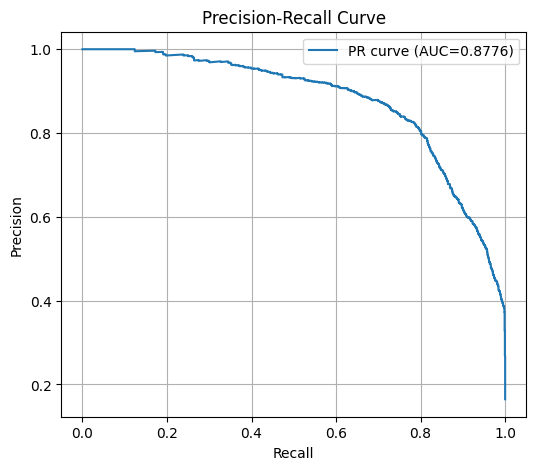

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f'PR curve (AUC={pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Only consider edges labeled as synthetic fraud
fraud_edges_idx = (edge_label.cpu().numpy() == 1)
fraud_src = src[fraud_edges_idx]
fraud_dst = dst[fraud_edges_idx]
fraud_amounts = edge_attr[fraud_edges_idx, 0].cpu().numpy()

In [ ]:
edges_per_ring = 6
sample_edges_idx = np.arange(edges_per_ring * 3)
sample_edges = [(fraud_src[i], fraud_dst[i]) for i in sample_edges_idx]
sample_amounts = [fraud_amounts[i] for i in sample_edges_idx]

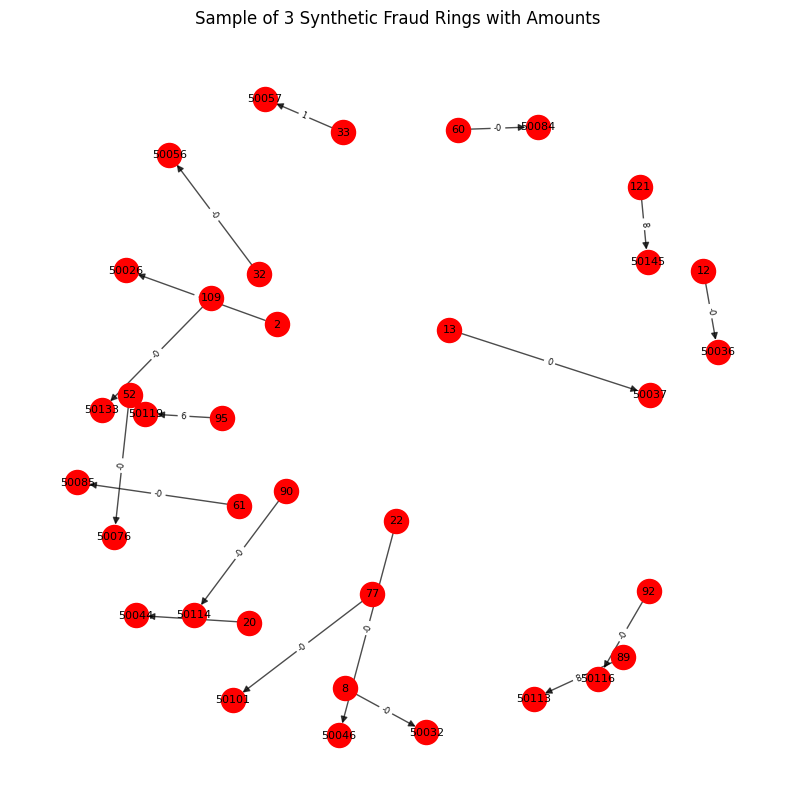

In [ ]:
# Build graph
G_sub = nx.DiGraph()
G_sub.add_edges_from(sample_edges)

# Draw
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_sub, k=0.5)
nx.draw_networkx_nodes(G_sub, pos, node_color='red', node_size=300)
nx.draw_networkx_edges(G_sub, pos, alpha=0.7)
nx.draw_networkx_labels(G_sub, pos, font_size=8)

# Edge labels = amounts
edge_labels = {edge: f"{amt:.0f}" for edge, amt in zip(sample_edges, sample_amounts)}
nx.draw_networkx_edge_labels(G_sub, pos, edge_labels=edge_labels, font_size=6)

plt.title("Sample of 3 Synthetic Fraud Rings with Amounts")
plt.axis('off')
plt.show()